In [1]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

from pylissom.utils.training import Pipeline
from torch.utils.data import Dataset, DataLoader
from pylissom.datasets.datasets import OrientatedGaussians

from pylissom.models.models import get_lissom 
from pylissom.utils.plotting import *
from pylissom.utils.helpers import debug


%autosave 60
%load_ext line_profiler

Autosaving every 60 seconds


## Training variables

In [2]:
size = 24
count = 10000
epochs = 1
orientations = 25

## Init and train Lissom

In [9]:
lissom, optimizer, _ = get_lissom(retinal_density=size, lgn_params='lgn', rlissom_params='rlissom', optim_params='optim')
display(lissom)

Lissom (
  (v1): ReducedLissom (
    (inhibitory_module): Cortex (20164 -> 20164, sigma=71.76, radius=34.5)
    (excitatory_module): Cortex (20164 -> 20164, sigma=11.076, radius=14.2)
    (afferent_module): Cortex (576 -> 20164, sigma=5.0, radius=6.5)
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.083, max_theta=0.633)
  , 576 -> 20164, settling_steps=9, afferent_strength=1.0, excitatory_strength=0.9, inhibitory_strength=0.9)
  (off): LGN (
    (diff_of_gaussians): DifferenceOfGaussiansLinear (576 -> 576, sigma_surround=2.0, sigma_center=0.5, radius=9.4, on=False)
    (strength): *2.33
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.0, max_theta=1.0)
  )
  (on): LGN (
    (diff_of_gaussians): DifferenceOfGaussiansLinear (576 -> 576, sigma_surround=2.0, sigma_center=0.5, radius=9.4, on=True)
    (strength): *2.33
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.0, max_theta=1.0)
  )
, 576 -> 20164)

In [8]:
gaussians_inputs = OrientatedGaussians(size=size, length=10000, gaussians=1)
train_loader = DataLoader(gaussians_inputs, shuffle=True, pin_memory=False)

In [ ]:
pipe = Pipeline(lissom, optimizer, cuda=True, log_interval=10)

## Inpect activation

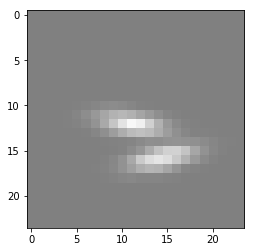

In [7]:
gauss, _ = iter(train_loader).next()
plot_tensor(gauss, (size, size), vmin=-1, vmax=1)

In [12]:
from pylissom.nn.modules.lissom import *

register_recursive_forward_hook(lissom, input_output_hook)
inp = Pipeline.process_input(torch.autograd.Variable(gauss).cuda())
out = lissom(inp)
plot_layer_activation(lissom, 'lissom')

NameError: name 'lissom' is not defined

In [5]:
pipe.train(train_loader, epoch=0)

KeyboardInterrupt: 

In [10]:
from pylissom.optim.optimizers import CortexHebbian 

In [11]:
from pylissom.nn.functional.weights import apply_circular_mask_to_weights

In [47]:
from src.utils.images import two_random_gaussians_generator 

In [48]:
from src.utils.datasets import RandomDataset#__getitem__

In [12]:
%lprun -f pipe._run -f CortexHebbian.hebbian_learning -f apply_circular_mask_to_weights pipe.train(train_loader, epochs)

UsageError: Could not find function 'pipe._run'.
NameError: name 'pipe' is not defined


## Calculate Orientations Maps

In [94]:
from src.supervised_gcal.orientation_maps import OrientationMap
from src.supervised_gcal.orientation_maps import get_oriented_lines

keys_arrays = get_oriented_lines(size, orientations=orientations)

In [95]:
keys_arrays = {k: map(lambda l: torch.autograd.Variable(l.cuda()), lines) for k, lines in keys_arrays.items()}

In [96]:
om = OrientationMap(model=lissom, inputs=keys_arrays)

orientation_map = om.get_orientation_map()
orientation_hist = om.get_orientation_hist()

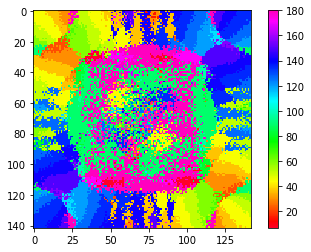

In [97]:
from src.supervised_gcal.orientation_maps import plot_orientation_map
plot_orientation_map(orientation_map)
plt.colorbar()
plt.show()

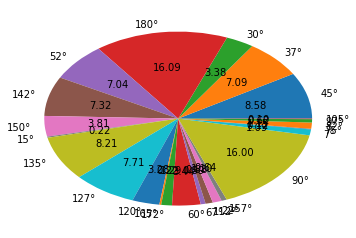

Promedio: %4.17
Standard deviation: %4.60


In [98]:
from src.supervised_gcal.orientation_maps import plot_orientation_hist, metrics_orientation_hist
plot_orientation_hist(orientation_hist)
plt.show()

mean, std = metrics_orientation_hist(orientation_hist)
print("Promedio: %{:.2f}".format(mean*100))
print("Standard deviation: %{:.2f}".format(std*100))